In [1]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
import seaborn as sns

In [4]:
import numpy as np
import pandas as pd

### access and read NINO3.4 from the BoM 

In [5]:
nino = "3.4"

In [6]:
url_nino = f"http://www.bom.gov.au/climate/enso/nino_{nino}.txt"

In [7]:
url_nino

'http://www.bom.gov.au/climate/enso/nino_3.4.txt'

In [8]:
r = requests.get(url_nino)

if r.status_code != 200: 
    print(f"something went wrong with accessing the URL {url_nino}")

else: 
    # read the weekly NINO index, and assign the end date of the weekly period 
    nino_index = pd.read_table(BytesIO(r.content), sep=',', header=None, index_col=1, parse_dates=True, names=['iDate','SST'])

### URL for the LongPaddock SOI 

In [9]:
url_soi = 'https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.txt'

In [10]:
r = requests.get(url_soi)

if r.status_code != 200: 
    print(f"something went wrong with accessing the URL {url_soi}")

else: 

    soi = pd.read_table(BytesIO(r.content), sep='\s+', engine='python') 

### create the index from year + day of year

In [11]:
index = [datetime(int(year),1,1) + timedelta(int(day)-1) for year, day in soi.loc[:,['Year','Day']].values]

In [12]:
soi.index = index

### calculates the monthly averages 

In [13]:
soi = soi.resample('1M').mean()

### get the date of today 

In [14]:
today = datetime.utcnow() - timedelta(15)

In [15]:
nino_index = nino_index.loc['2019-01':'2020-08',:]

In [16]:
nino_index = nino_index.resample('1M').mean()

In [17]:
dates = nino_index.index.to_pydatetime()

In [18]:
dates_str = [f"{x:%b %Y}" for x in dates]

In [19]:
basis = np.arange(len(dates))

In [20]:
nino_values = nino_index.SST.values

### merge the NINO and SOI index 

In [21]:
ENSO_index = pd.concat([nino_index, soi], axis=1)

In [22]:
ENSO_index = ENSO_index.dropna()

In [23]:
ENSO_index.head()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2019-01-31,20187893.25,0.4675,2019.0,16.0,1011.036774,1006.838710,-1.104839
2019-02-28,20190190.25,0.4700,2019.0,45.5,1010.704643,1008.960714,-13.375000
2019-03-31,20190296.60,0.8060,2019.0,75.0,1011.083548,1008.425806,-6.995484
2019-04-30,20190411.50,0.7650,2019.0,105.5,1012.232000,1010.143333,-2.147333
2019-05-31,20190492.00,0.7200,2019.0,136.0,1012.842258,1012.311290,-8.759355


In [24]:
ENSO_index.tail()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2020-04-30,20200392.25,0.5375,2020.0,106.5,1012.804667,1010.546667,-0.756000
2020-05-31,20200497.00,-0.0260,2020.0,137.0,1014.314194,1012.350000,2.559677
2020-06-30,20200611.50,-0.1250,2020.0,167.5,1012.901333,1012.945000,-9.908667
2020-07-31,20200692.00,0.0425,2020.0,198.0,1014.284194,1012.708065,4.016452
2020-08-31,20200796.20,-0.4160,2020.0,229.0,1015.644194,1012.501613,9.394194


### selects only the columns we actually need 

In [25]:
ENSO_index = ENSO_index.loc[:,['SST','SOI']]

### divides the SOI by 10 to get something closer to the NIWA SOI 

In [26]:
ENSO_index.loc[:,'SOI'] /= 10.

In [27]:
ENSO_index.head()

,SST,SOI
2019-01-31,0.4675,-0.110484
2019-02-28,0.4700,-1.337500
2019-03-31,0.8060,-0.699548
2019-04-30,0.7650,-0.214733
2019-05-31,0.7200,-0.875935


In [28]:
ENSO_index.tail()

,SST,SOI
2020-04-30,0.5375,-0.075600
2020-05-31,-0.0260,0.255968
2020-06-30,-0.1250,-0.990867
2020-07-31,0.0425,0.401645
2020-08-31,-0.4160,0.939419


In [29]:
soi_values = ENSO_index.SOI.values

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [30]:
enso_cat = pd.read_csv('../template/template_Pacific_RCC_ENSO_tracker.csv')

In [31]:
enso_cat

,YEAR,MONTH,NOAA,BoM,APCC,NIWA
0,2019,1,neutral,El_Nino_alert,neutral,El_Nino_watch
1,2019,2,El_Nino,El_Nino_watch,El_Nino,El_Nino_alert
2,2019,3,El_Nino,El_Nino_watch,El_Nino,El_Nino
3,2019,4,El_Nino,El_Nino_alert,El_Nino,El_Nino
4,2019,5,El_Nino,El_Nino_watch,El_Nino,El_Nino
5,2019,6,El_Nino,El_Nino_watch,El_Nino,El_Nino
6,2019,7,El_Nino,neutral,neutral,El_Nino
7,2019,8,neutral,neutral,neutral,neutral
8,2019,9,neutral,neutral,neutral,neutral
9,2019,10,neutral,neutral,neutral,neutral


In [32]:
cat_to_int = {} 

cat_to_int['La_Nina'] = -3
cat_to_int['La_Nina_alert'] = -2
cat_to_int['La_Nina_watch'] = -1
cat_to_int['neutral'] = 0
cat_to_int['El_Nino_watch'] = 1 
cat_to_int['El_Nino_alert'] = 2 
cat_to_int['El_Nino'] = 3

In [33]:
enso_cat_int = enso_cat.replace(cat_to_int)

In [34]:
enso_cat_int.loc[:,'date'] = np.NaN

In [35]:
enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)

In [36]:
enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1)

In [37]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [38]:
enso_cat_int.shape

(20, 4)

In [39]:
len(dates)

20

In [40]:
enso_cat_int

,NOAA,BoM,APCC,NIWA
date,,,,
2019-01,0,2,0,1
2019-02,3,1,3,2
2019-03,3,1,3,3
2019-04,3,2,3,3
2019-05,3,1,3,3
2019-06,3,1,3,3
2019-07,3,0,0,3
2019-08,0,0,0,0
2019-09,0,0,0,0


In [41]:
nino_index

,iDate,SST
2019-01-31,20187893.25,0.4675
2019-02-28,20190190.25,0.4700
2019-03-31,20190296.60,0.8060
2019-04-30,20190411.50,0.7650
2019-05-31,20190492.00,0.7200
2019-06-30,20190596.20,0.7020
2019-07-31,20190711.50,0.5400
2019-08-31,20190791.25,0.2150
2019-09-30,20190895.20,0.0040
2019-10-31,20190993.00,0.5375


20

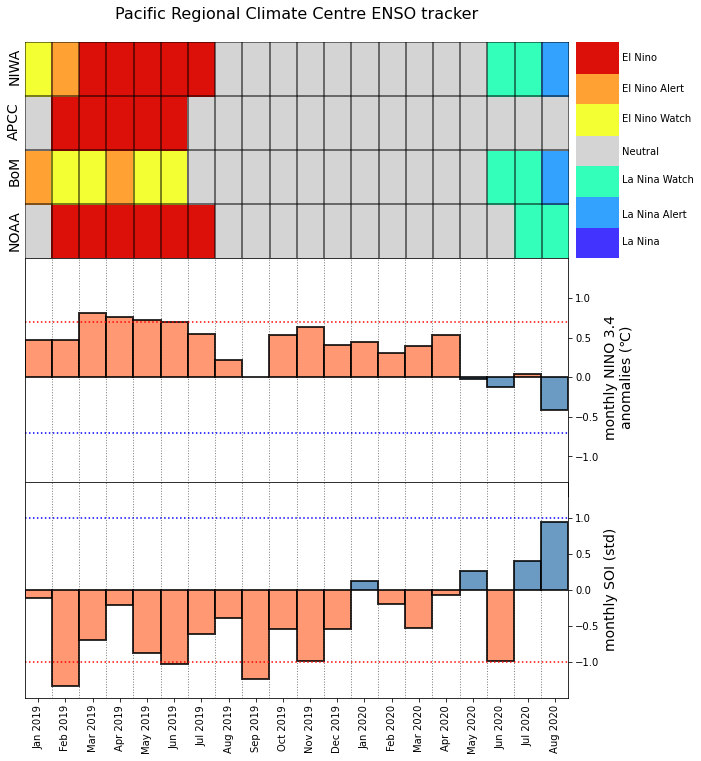

In [48]:
f = plt.figure(figsize=(10,10))

# defines the axes [left, bottom, width, height]

ax0 = f.add_axes([0.1, 0.66, 0.9, 0.3])

ax0.set_title("Pacific Regional Climate Centre ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.33, 0.755, 0.33])

ax2 = f.add_axes([0.1, 0.05, 0.755, 0.30])

#============================================================================================================================
# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.8, 1.8, 2.8, 3.8]);

ax0.set_yticklabels(['NOAA','BoM','APCC','NIWA'], fontsize=14)

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,len(enso_cat_int) + 1)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,5)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)

#============================================================================================================================
# second set of axes: ENSO barplot

ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)

ax1.set_xlim([-0.5,len(dates) - 0.5])

ax1.set_ylim([-1.5, 1.5])

ax1.set_yticks([-1., -0.5, 0, 0.5, 1.])

ax1.axhline(-0.7, ls=':', color='b')
ax1.axhline(0.7, ls=':', color='r')

ax1.yaxis.tick_right()

ax1.set_ylabel('monthly NINO 3.4\nanomalies (℃)', fontsize=14)

ax1.yaxis.set_label_position("right")

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

ax1.set_xlabel('month', fontsize=14)

#============================================================================================================================
# second set of axes: SOI barplot

ax2.bar(basis[soi_values>=0],soi_values[soi_values>=0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)
ax2.bar(basis[soi_values<0],soi_values[soi_values<0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)

ax2.set_xticks(basis)

ax2.set_xticklabels(dates_str, rotation=90)

ax2.set_xlim([-0.5,len(dates) - 0.5])

ax2.set_ylim([-1.5, 1.5])

ax2.set_yticks([-1., -0.5, 0, 0.5, 1.])

ax2.axhline(-1, ls=':', color='r')
ax2.axhline(1, ls=':', color='b')

ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

ax2.set_ylabel('monthly SOI (std)', fontsize=14)

ax2.yaxis.set_label_position("right")

[ax2.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

In [49]:
f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')